# Genre Classification using IMDb movie summaries
## Group 68

In [1]:
#import libraries
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns

from tqdm import tqdm
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

## 1. Load data into a Pandas Dataframe

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
file_path= 'data/collected_imdb.csv'
movies = pd.read_csv(file_path, index_col=0)
movies.head()

,movie,genre,summary,labelled_genre
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",The people of Wakanda fight to protect their h...,A
1,Enola Holmes 2,"Action,Adventure,Crime","Now a detective-for-hire, Enola Holmes takes o...",A
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music","Explores every facet of Yankovic's life, from ...",B
3,The Whale,Drama,A reclusive English teacher attempts to reconn...,D
4,Don't Worry Darling,"Drama,Thriller",A 1950s housewife living with her husband in a...,D


In [4]:
movies.describe()

,movie,genre,summary,labelled_genre
count,117460,117460,117460,117460
unique,67265,1401,70142,36
top,The Three Musketeers,Drama,Add a Plot,Comedy
freq,34,5290,4056,20503


### Observations
- Only ~67k out of ~117 million movies are unique. Hence, we remove duplicate movies.
- The most frequent summary is `Add a Plot`. These movies don't have any summaries and hence, need to be discarded.
- `labelled_genre` is extremely diverse and needs to be standardized.

In [5]:
movies=movies.drop_duplicates(subset='movie')
movies = movies[movies["summary"].str.contains("Add a Plot") == False]
movies = movies.reset_index(drop=True)
movies

,movie,genre,summary,labelled_genre
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",The people of Wakanda fight to protect their h...,A
1,Enola Holmes 2,"Action,Adventure,Crime","Now a detective-for-hire, Enola Holmes takes o...",A
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music","Explores every facet of Yankovic's life, from ...",B
3,The Whale,Drama,A reclusive English teacher attempts to reconn...,D
4,Don't Worry Darling,"Drama,Thriller",A 1950s housewife living with her husband in a...,D
...,...,...,...,...
64009,The EBay Pickup,"Documentary,Short,Action","After winning a bid on EBay, Pat travels far f...",Sci-Fi
64010,Underland Episode III: Beyond the Rift,"Action,Adventure,Comedy",UNDERLAND' takes us along for the journey of a...,Sci-Fi
64011,The Turtle and the Time Machine,"Comedy,Drama,Sci-Fi",Three 20-somethings roam the Tennessee country...,Sci-Fi
64012,Form Function,"Documentary,Short,Sci-Fi",This purely visual short film shows an industr...,Sci-Fi


## 2. Data Preprocessing

### A. The summaries are cleaned by:
    1. removing any `\`, `'`, or trailing whitespace
    2. keeping only lower-case alphabets

In [6]:
def clean_dataset(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [7]:
movies['clean_summary'] = movies['summary'].apply(lambda x: clean_dataset(x))
movies.head(5)

,movie,genre,summary,labelled_genre,clean_summary
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",The people of Wakanda fight to protect their h...,A,the people of wakanda fight to protect their h...
1,Enola Holmes 2,"Action,Adventure,Crime","Now a detective-for-hire, Enola Holmes takes o...",A,now a detective for hire enola holmes takes on...
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music","Explores every facet of Yankovic's life, from ...",B,explores every facet of yankovics life from hi...
3,The Whale,Drama,A reclusive English teacher attempts to reconn...,D,a reclusive english teacher attempts to reconn...
4,Don't Worry Darling,"Drama,Thriller",A 1950s housewife living with her husband in a...,D,a s housewife living with her husband in a uto...


In [8]:
del movies['summary']

### B. Most frequent words in summaries

We plot the frequency of the most frequently occuring words in the summaries. We observe that:
1. Words such as `the`, `a`, `and`, `to`, etc.(stopwords) occupy approximately the first 50 most frequent words.
2. The word-frequency distribution is heavily skewed due to these stopwords. Therefore, a model trained on these summaries will give more importance to them, over actual genre-defining words. This will lead to noisy predictions.

In [9]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

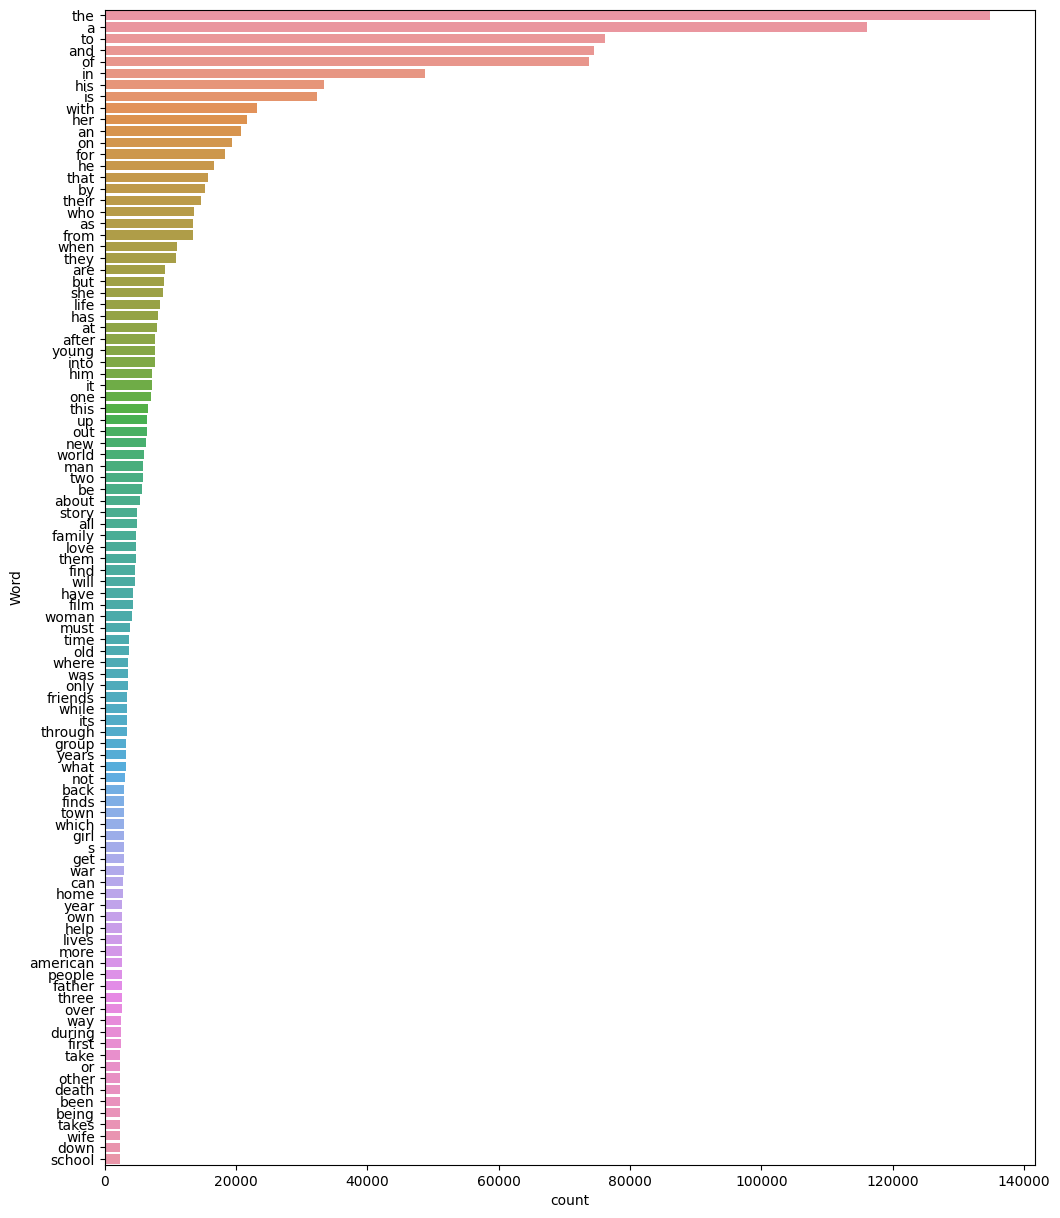

In [10]:
freq_words(movies['clean_summary'], 100)

### C. Removal of stopwords, stemming in summaries

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niharika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies['clean_summary'] = movies['clean_summary'].apply(lambda x: remove_stopwords(x))

movies['stemmed_summary'] = movies['clean_summary'].str.split()
movies['stemmed_summary'] = movies['stemmed_summary'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
movies['stemmed_summary'] = movies['stemmed_summary'].apply(lambda x: ' '.join(x))
movies

,movie,genre,labelled_genre,clean_summary,stemmed_summary
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",A,people wakanda fight protect home intervening ...,peopl wakanda fight protect home interven worl...
1,Enola Holmes 2,"Action,Adventure,Crime",A,detective hire enola holmes takes first offici...,detect hire enola holm take first offici case ...
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music",B,explores every facet yankovics life meteoric r...,explor everi facet yankov life meteor rise fam...
3,The Whale,Drama,D,reclusive english teacher attempts reconnect e...,reclus english teacher attempt reconnect estra...
4,Don't Worry Darling,"Drama,Thriller",D,housewife living husband utopian experimental ...,housewif live husband utopian experiment commu...
...,...,...,...,...,...
64009,The EBay Pickup,"Documentary,Short,Action",Sci-Fi,winning bid ebay pat travels far home pick unu...,win bid ebay pat travel far home pick unusu it...
64010,Underland Episode III: Beyond the Rift,"Action,Adventure,Comedy",Sci-Fi,underland takes us along journey young girl th...,underland take us along journey young girl thr...
64011,The Turtle and the Time Machine,"Comedy,Drama,Sci-Fi",Sci-Fi,three somethings roam tennessee countryside se...,three someth roam tennesse countrysid search t...
64012,Form Function,"Documentary,Short,Sci-Fi",Sci-Fi,purely visual short film shows industrial desi...,pure visual short film show industri design cr...


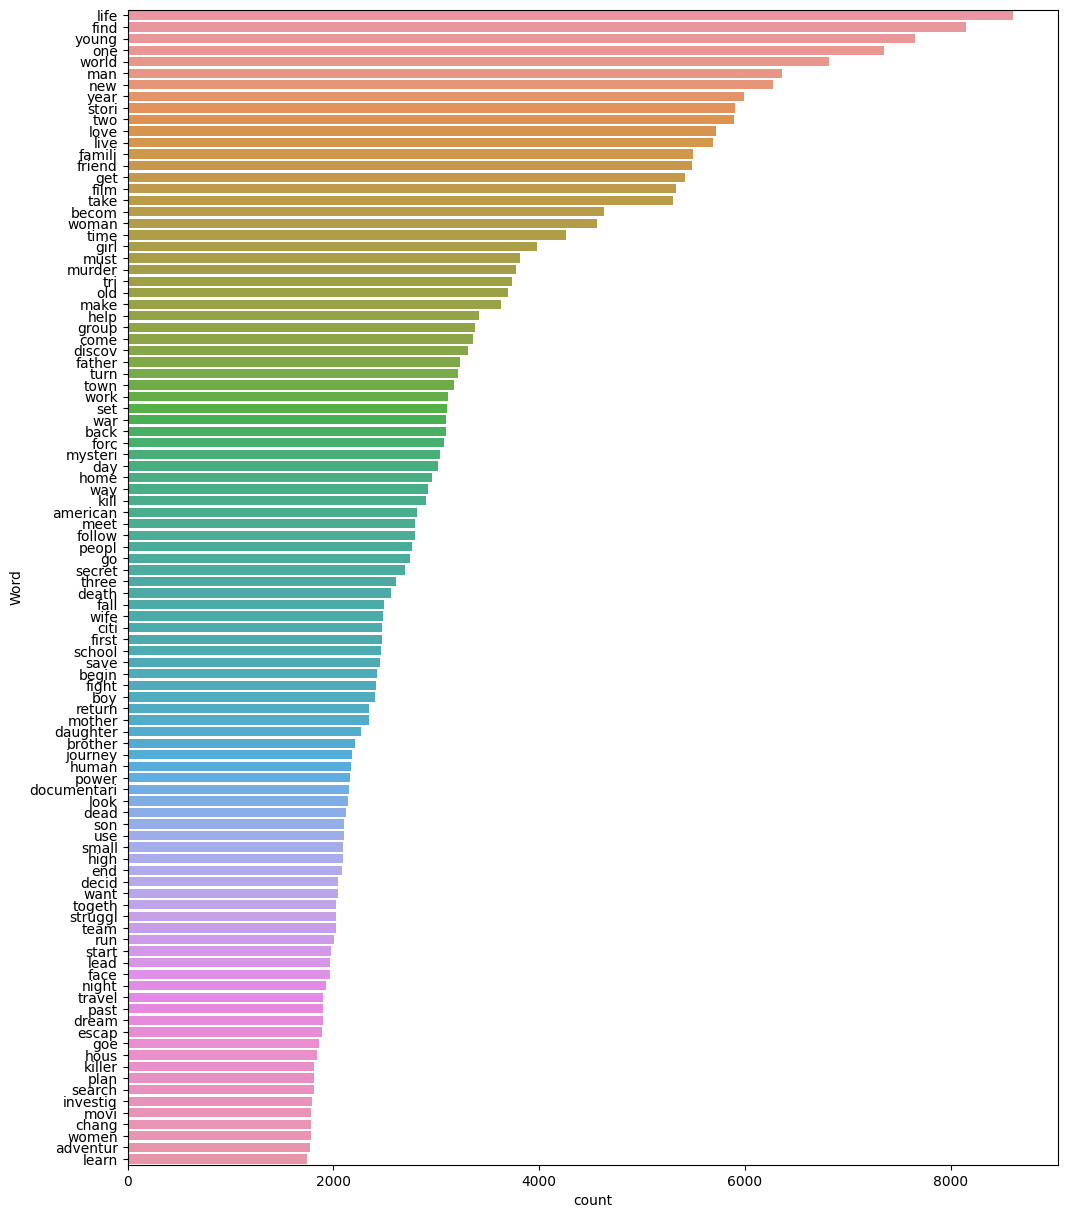

In [13]:
movies['summary'] = movies['stemmed_summary']
del movies['clean_summary']
del movies['stemmed_summary']
freq_words(movies['summary'], 100)

In [14]:
movies["Number of Words"] = movies["summary"].apply(lambda n: len(n.split()))
movies['Number of Words'].describe()

count    64014.000000
mean        22.236042
std         20.181776
min          1.000000
25%         12.000000
50%         17.000000
75%         23.000000
max        612.000000
Name: Number of Words, dtype: float64

### Observations:
1. After removal of stopwords, more significant words such as `life`, `world`, `love`, `family`, `documentary` will get attention from the models to predict genre.
2. Each word is stemmed into their base-form to standardize the data without losing its overall meaning. This reduces noisyness (unneccesary variance) in the data even when the meaning is essentially the same. For e.g.:
    - `takes` and `taken` becomes `take`.
    - `running`, `run`, `ran` becomes `run`. 
3. The frequency distribution is highly uniform after the first top 10 words, thereby reducing bias.
4. Each summary is of variable length. The maximum number of words in a summary is `612`, whereas 75% of the summaries are `23` words or less. Hence, we can safely assume `~25` features in each summary without losing generality.

### D. Preprocessing labels

In [15]:
movies['labelled_genre'] = movies['genre'].str.split(',')
movies['labelled_genre'] = movies['labelled_genre'].apply(lambda x: x[0])
movies

,movie,genre,labelled_genre,summary,Number of Words
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",Action,peopl wakanda fight protect home interven worl...,12
1,Enola Holmes 2,"Action,Adventure,Crime",Action,detect hire enola holm take first offici case ...,21
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music",Biography,explor everi facet yankov life meteor rise fam...,21
3,The Whale,Drama,Drama,reclus english teacher attempt reconnect estra...,8
4,Don't Worry Darling,"Drama,Thriller",Drama,housewif live husband utopian experiment commu...,14
...,...,...,...,...,...
64009,The EBay Pickup,"Documentary,Short,Action",Documentary,win bid ebay pat travel far home pick unusu it...,11
64010,Underland Episode III: Beyond the Rift,"Action,Adventure,Comedy",Action,underland take us along journey young girl thr...,24
64011,The Turtle and the Time Machine,"Comedy,Drama,Sci-Fi",Comedy,three someth roam tennesse countrysid search t...,8
64012,Form Function,"Documentary,Short,Sci-Fi",Documentary,pure visual short film show industri design cr...,15


<AxesSubplot:>

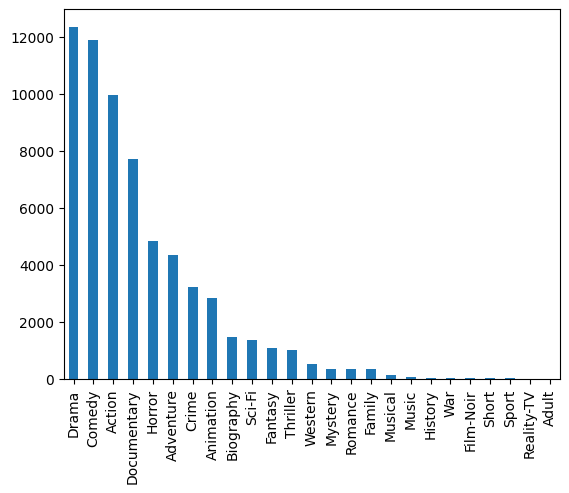

In [40]:
movies.labelled_genre.value_counts().plot(kind = 'bar')

### Observations:
1. Each movie was assigned the first label in the `genre` column. There are a total of 25 genres with unequal distribution across the dataset.
2. We select the top 5 main genres as our final labels `(Y)` and map the other genres to these 5 in either of the 2 ways:
    - For each movie, loop over the `genre` column and assign it the first genre which belongs to `Y`.
    - If none of the genres belong to `Y`, use the `genre_map` dictionary to manually assign it a label from `Y`.
3. This helps to create a focussed and uniform dataset by having broader categories and lesser noise (as the movies with genres like `Sport`, `Adult` won't have correct predictions anyway due to very less data).

In [41]:
interested = ['Drama', 'Comedy', 'Action', 'Documentary', 'Horror']
genre_map = {
    'Adventure': 'Action', 
    'Biography': 'Documentary',
    'Crime': 'Action',
    'Animation': 'Drama',
    'Thriller': 'Horror',
    'Western': 'Drama',
    'Romance': 'Drama',
    'Fantasy': 'Horror',
    'Sci-Fi': 'Action',
    'Mystery': 'Horror',
    'Family': 'Drama',
    'Musical': 'Comedy',
    'Music': 'Comedy',
    'History': 'Documentary',
    'War': 'Action',
    'Film-Noir': 'Action',
    'Sport': 'Action',
    'Short': 'Drama',
    'Reality-TV': 'Documentary',
    'Adult': 'Comedy'
    }
new_genres = []

for row in movies['genre'].str.split(','):
    flag=0
    for genre in row:
        if genre in interested:
            new_genres.append(genre)
            flag=1
            break
    if flag == 0:
        new_genres.append(genre_map[row[0]])
        
movies['new_genre'] = new_genres
movies

,movie,genre,labelled_genre,summary,Number of Words,new_genre
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",Action,peopl wakanda fight protect home interven worl...,12,Action
1,Enola Holmes 2,"Action,Adventure,Crime",Action,detect hire enola holm take first offici case ...,21,Action
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music",Biography,explor everi facet yankov life meteor rise fam...,21,Comedy
3,The Whale,Drama,Drama,reclus english teacher attempt reconnect estra...,8,Drama
4,Don't Worry Darling,"Drama,Thriller",Drama,housewif live husband utopian experiment commu...,14,Drama
...,...,...,...,...,...,...
64009,The EBay Pickup,"Documentary,Short,Action",Documentary,win bid ebay pat travel far home pick unusu it...,11,Documentary
64010,Underland Episode III: Beyond the Rift,"Action,Adventure,Comedy",Action,underland take us along journey young girl thr...,24,Action
64011,The Turtle and the Time Machine,"Comedy,Drama,Sci-Fi",Comedy,three someth roam tennesse countrysid search t...,8,Comedy
64012,Form Function,"Documentary,Short,Sci-Fi",Documentary,pure visual short film show industri design cr...,15,Documentary


<AxesSubplot:>

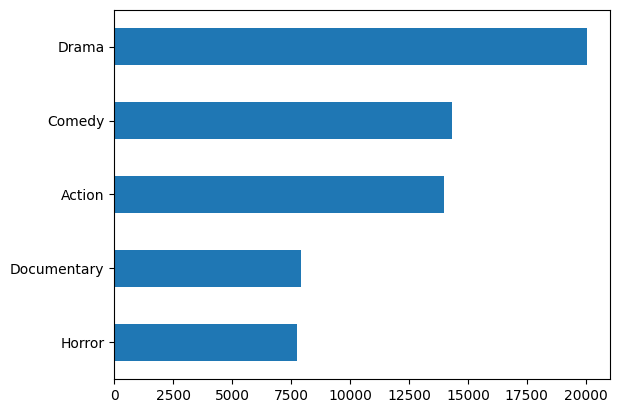

In [43]:
movies.new_genre.value_counts().sort_values().plot(kind = 'barh')

In [44]:
movies['labelled_genre'] = movies['new_genre']
del movies['new_genre']
del[movies['Number of Words']]
movies.to_csv('data/cleaned_imdb.csv')

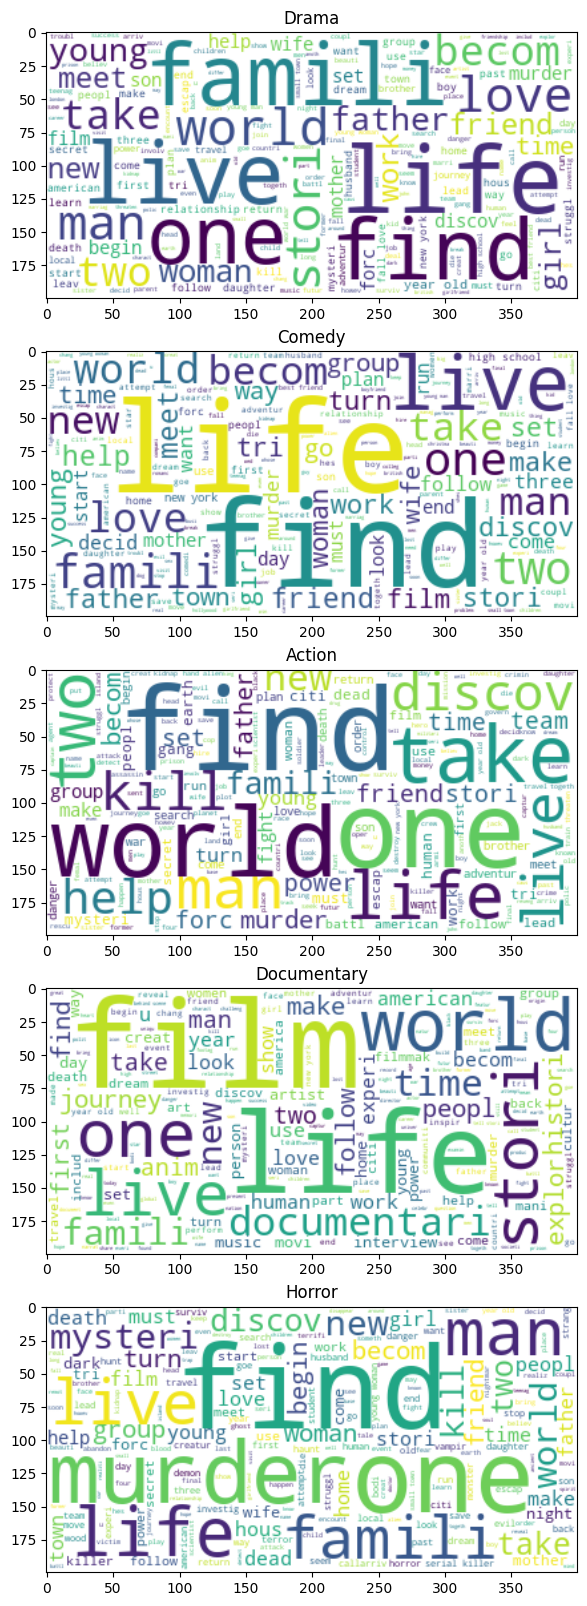

In [61]:
fig, ax = plt.subplots(5, figsize=(20, 20))
i = 0

for genre in interested:
    summary = movies[movies.labelled_genre == genre]['summary']
    text = " ".join(i for i in summary)
    wordcloud = WordCloud(background_color="white").generate(text)
    ax[i].set_title(genre)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    i += 1

### Observations:
1. We create wordclouds for each of our 5 label genres. Following observations from each wordcloud shows the correlation of summaries to its respective genres:
- Drama: `live, love, life, family, story`
- Comedy: `live, love, find, family`
- Action: `kill, gang, power, murder, world, help`
- Documentary: `film, life, documentary, person, people, journey`
- Horror: `murder, mysteri, kill, dead, force, man`

As is intuitive, these words do give an idea about the genre of a movie solely from its meaning.

2. However, it is to note that `Drama` and `Comedy` have very similar wordclouds. Also, `Action` and `Horror` are correlated. Hence, it is possible that the neural networks are not able to differentiate between these 2 pairs very well, thereby leading to incorrect predictions.